In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from package.Data import Dataset, Audio
from package.Kernels import Normalize, Dropna
from package.FeatureSelection import tStudent
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

class Pipeline:
    def __init__(self, processList):
        self.processList =  processList
    
    def transform(self, dataset):
        for process in self.processList:
            dataset = process.transform(dataset)
        return dataset

# Preprocessing and Feature Selection

In [3]:
isna = []
mini = []
maxi = []

# First Dataset
dataset1 = Dataset.load('Acted Emotional Speech Dynamic Database')
norm1 = Normalize()
dataset = norm1.fit(dataset1)
dropna1 = Dropna()
dropna1.fit(dataset)


# Second Dataset
dataset2 = Dataset.load('CaFE_48k')
norm2 = Normalize()
dataset = norm2.fit(dataset2)
dropna2 = Dropna()
dropna2.fit(dataset)


# Third Dataset
dataset3 = Dataset.load('emoSynth-DB')
norm3 = Normalize()
dataset = norm3.fit(dataset3)
dropna3 = Dropna()
dropna3.fit(dataset)

# Creating Preprocessing Pipeline
dropna = Dropna()
dropna.isna = dropna1.isna | dropna3.isna | dropna3.isna 

norm = Normalize()
norm.min = pd.concat([norm1.min, norm2.min, norm3.min], axis=1).min(axis=1)
norm.max = pd.concat([norm1.max, norm2.max, norm3.max], axis=1).max(axis=1)

pipeline = Pipeline([norm, dropna])

dataset1 = pipeline.transform(Dataset.load('Acted Emotional Speech Dynamic Database'))
dataset2 = pipeline.transform(Dataset.load('CaFE_48k'))
dataset3 = pipeline.transform(Dataset.load('emoSynth-DB'))

# Feature Selection with t-Student
tstudent1 = tStudent(threshold = 0.8)
tstudent1.fit(dataset1)

tstudent2 = tStudent(threshold = 0.8)
tstudent2.fit(dataset2)

tstudent = tStudent()
tstudent.selection = list(set(tstudent1.selection) and set(tstudent2.selection))

pipeline.processList.append(tstudent)

In [62]:
dataset1 = pipeline.transform(Dataset.load('Acted Emotional Speech Dynamic Database'))
dataset2 = pipeline.transform(Dataset.load('CaFE_48k'))
dataset3 = pipeline.transform(Dataset.load('emoSynth-DB'))
# Normalize y between [0,1] of dataset3
dataset3.y = (dataset3.y - dataset3.y.min()) / (dataset3.y.max() - dataset3.y.min())

# MODEL TRAINING

In [5]:
from tensorflow import keras as kr
import tensorflow as tf
import numpy as np

In [40]:
def tensorflow_dataset1(batch_size):
    X_train, X_test, y_train, y_test = [i.values for i in dataset1.split()]
    # y is an array of strings (class labels)

    # Reserve 10% of training for validation.
    split_mark = int(X_train.shape[0] * 0.1)
    X_train, X_val, y_train, y_val = X_train[:-split_mark], X_train[-split_mark:], y_train[:-split_mark], y_train[-split_mark:]

    # One hot encode the labels.
    y_train, y_val, y_test = [OneHotEncoder().fit_transform(y).toarray() for y in [y_train, y_val, y_test]]

    # Prepare the training dataset. and change the labels to one-hot encoding
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

    # Prepare the validation dataset.
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_dataset = val_dataset.batch(batch_size)

    # Prepare the test dataset.
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    test_dataset = test_dataset.batch(batch_size)

    return train_dataset, val_dataset, test_dataset

def tensorflow_dataset2(batch_size):
    X_train, X_test, y_train, y_test = [i.values for i in dataset2.split()]
    # y is an array of strings (class labels)

    # Reserve 10% of training for validation.
    split_mark = int(X_train.shape[0] * 0.1)
    X_train, X_val, y_train, y_val = X_train[:-split_mark], X_train[-split_mark:], y_train[:-split_mark], y_train[-split_mark:]

    # One hot encode the labels.
    y_train, y_val, y_test = [OneHotEncoder().fit_transform(y).toarray() for y in [y_train, y_val, y_test]]

    # Prepare the training dataset. and change the labels to one-hot encoding
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

    # Prepare the validation dataset.
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_dataset = val_dataset.batch(batch_size)

    # Prepare the test dataset.
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    test_dataset = test_dataset.batch(batch_size)

    return train_dataset, val_dataset, test_dataset

def tensorflow_dataset3(batch_size):
    X_train, X_test, y_train, y_test = [i.values for i in dataset3.split()]
    # y is an array of values (nObservations, 2)

    # Reserve 10% of training for validation.
    split_mark = int(X_train.shape[0] * 0.1)
    X_train, X_val, y_train, y_val = X_train[:-split_mark], X_train[-split_mark:], y_train[:-split_mark], y_train[-split_mark:]

    # no need to one hot enconde as model will be trained on the output of the network

    # Prepare the training dataset.
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

    # Prepare the validation dataset.
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_dataset = val_dataset.batch(batch_size)

    # Prepare the test dataset.
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    test_dataset = test_dataset.batch(batch_size)

    return train_dataset, val_dataset, test_dataset

2022-05-31 16:09:15.182362: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/ser/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


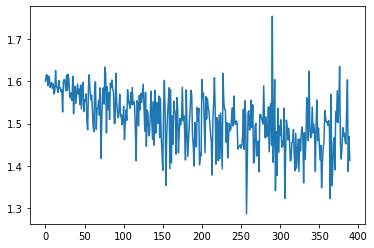

In [7]:
# Single Model Trainer for first dataset

# Prepare the training dataset.
train_dataset, val_dataset, test_dataset = tensorflow_dataset1(batch_size=32)

input_shape = (len(tstudent.selection),)
output_size = train_dataset.element_spec[1].shape[1] # Probability of each class

inputs = kr.layers.Input(shape=input_shape)
latent = kr.layers.Dense(100, activation='relu')(inputs)
outputs = kr.layers.Dense(output_size, activation='softmax')(latent)
model = kr.models.Model(inputs= inputs, outputs = outputs)

opt = kr.optimizers.Adam()
loss_fn = kr.losses.CategoricalCrossentropy(from_logits=True)

# Prepare the training dataset.
%matplotlib inline
epochs = 5
losses = []
for epoch in range(epochs):
    for step, (x, y) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x)
            loss = loss_fn(y, logits)
        grads = tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(grads, model.trainable_variables))
        losses.append(loss.numpy())

# plot loss
plt.clf()
plt.plot(losses)
plt.pause(0.01)


/opt/anaconda3/envs/ser/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


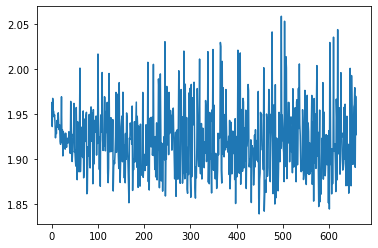

In [8]:
# Single Model Trainer for second dataset

# Prepare the training dataset.
train_dataset, val_dataset, test_dataset = tensorflow_dataset2(batch_size=32)

input_shape = (len(tstudent.selection),)
output_size = train_dataset.element_spec[1].shape[1] # Probability of each class

inputs = kr.layers.Input(shape=input_shape)
latent = kr.layers.Dense(100, activation='relu')(inputs)
outputs = kr.layers.Dense(output_size, activation='softmax')(latent)
model = kr.models.Model(inputs= inputs, outputs = outputs)

opt = kr.optimizers.Adam()
loss_fn = kr.losses.CategoricalCrossentropy(from_logits=True)

# Prepare the training dataset.
%matplotlib inline
epochs = 5
losses = []
for epoch in range(epochs):
    for step, (x, y) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x)
            loss = loss_fn(y, logits)
        grads = tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(grads, model.trainable_variables))
        losses.append(loss.numpy())

# plot loss
plt.clf()
plt.plot(losses)
plt.pause(0.01)

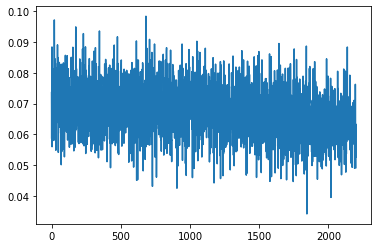

In [66]:
# Single Model Trainer for third dataset

# Prepare the training dataset.
train_dataset, val_dataset, test_dataset = tensorflow_dataset3(batch_size=32)

input_shape = (len(tstudent.selection),)
output_size = train_dataset.element_spec[1].shape[1] # Probability of each class

inputs = kr.layers.Input(shape=input_shape)
latent = kr.layers.Dense(100, activation='relu')(inputs)
outputs = kr.layers.Dense(output_size, activation='sigmoid')(latent)
model = kr.models.Model(inputs= inputs, outputs = outputs)

opt = kr.optimizers.Adam()
loss_fn = tf.keras.losses.MeanSquaredError()

# Prepare the training dataset.
%matplotlib inline
epochs = 50
losses = []
for epoch in range(epochs):
    for step, (x, y) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            logits = model(x)
            loss = loss_fn(y, logits)
        grads = tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(grads, model.trainable_variables))
        losses.append(loss.numpy())

# plot loss
plt.clf()
plt.plot(losses)
plt.pause(0.01)

In [85]:
# MultiHead Model Trainer

# Prepare the training dataset.
datasets = [
    tensorflow_dataset1(batch_size=32), 
    tensorflow_dataset2(batch_size=32), 
    tensorflow_dataset3(batch_size=32)
    ]

input_shape = (len(tstudent.selection),)

output_sizes = [
    datasets[0][0].element_spec[1].shape[1],
    datasets[1][0].element_spec[1].shape[1],
    datasets[2][0].element_spec[1].shape[1]
]

inputs = kr.layers.Input(shape=input_shape)
hiddenLayer = kr.layers.Dense(100, activation='relu')

outputLayer = [
    kr.layers.Dense(output_sizes[0], activation='softmax'),
    kr.layers.Dense(output_sizes[1], activation='softmax'),
    kr.layers.Dense(output_sizes[2], activation='sigmoid')
]

opt = kr.optimizers.Adam()
loss_fn = [
    kr.losses.CategoricalCrossentropy(),
    kr.losses.CategoricalCrossentropy(),
    tf.keras.losses.MeanSquaredError()
]

# Prepare the training dataset.
losses = [[] for _ in datasets]
for it in range(50000):
    for i in range(len(datasets)):
        train_dataset, val_dataset, test_dataset = datasets[i]
        # Get random batch
        x, y = train_dataset.take(1).as_numpy_iterator().next()
        with tf.GradientTape() as tape:
            latent = hiddenLayer(x)
            output = outputLayer[i](latent)
            loss = loss_fn[i](y, output)
        # Calculate output and hidden layer loss 
        grads = tape.gradient(
            loss, 
            hiddenLayer.trainable_variables + outputLayer[i].trainable_variables
        )
        # Apply gradients to hidden layer and output layer
        opt.apply_gradients(
            zip(grads, hiddenLayer.trainable_variables + outputLayer[i].trainable_variables)
        )
        # remember to average all losses in mse
        losses[i].append(loss.numpy())

    if it % 1000 == 0:
        losses_np = np.array(losses).T
        losses_np = losses_np/losses_np[0]

        plt.clf()
        plt.plot(losses_np)
        plt.legend(['Dataset 1', 'Dataset 2', 'Dataset 3'])
        plt.pause(0.01)


2022-05-31 16:38:24.034432: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-05-31 16:38:30.090229: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-05-31 16:38:30.190230: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-05-31 16:38:30.223284: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-05-31 16:38:30.239153: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-05-31 16:38:30.252437: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-05-31 16:38:30.883195: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
2022-05-31 16:38:30.911017: W tensorflow/core/data/root_dataset.cc:16